In [ ]:
#!pip install tensorflow==2.2.0
#!pip install keras==2.3.0
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.4.1
2.4.3


In [ ]:
import matplotlib.pyplot as plt
import os
from shutil import copyfile
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [ ]:
celebrity_path='/content/drive/My Drive/celebrity_dataset'
work_dir = os.getcwd() # trenutni radni direktorij
celebritys = os.listdir(celebrity_path)
celebritys

['pins_barbara palvin',
 'pins_Brian J. Smith',
 'pins_Chris Evans',
 'pins_Alexandra Daddario',
 'pins_Bill Gates',
 'pins_camila mendes',
 'pins_Chris Pratt',
 'pins_Alvaro Morte',
 'pins_Alex Lawther',
 'pins_Adriana Lima',
 'pins_elon musk',
 'pins_Josh Radnor',
 'pins_Emilia Clarke',
 'pins_Leonardo DiCaprio',
 'pins_Rihanna',
 'pins_Madelaine Petsch',
 'pins_kiernen shipka',
 'pins_Megan Fox',
 'pins_Jason Momoa',
 'pins_Robert De Niro',
 'pins_Selena Gomez',
 'pins_barack obama',
 'pins_Emma Watson',
 'pins_Johnny Depp',
 'pins_Chris Hemsworth',
 'pins_Cristiano Ronaldo',
 'pins_Tom Cruise',
 'pins_Zac Efron',
 'pins_scarlett johansson',
 'pins_Miley Cyrus',
 'pins_Jennifer Lawrence',
 'pins_Ben Affleck',
 'pins_ellen page',
 'pins_Henry Cavil',
 'pins_Morgan Freeman']

In [ ]:
train_dir = os.path.join(work_dir,'train')        
test_dir = os.path.join(work_dir,'test')         
os.makedirs(train_dir, exist_ok=True)  # train podaci
os.makedirs(test_dir, exist_ok=True)   # test podaci

In [ ]:
train_ratio=0.8
test_ratio=0.2
dir_list = os.listdir(celebrity_path)

In [ ]:
# xml file za detektiranje lica
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml"
!wget {url} -P ./

--2021-03-13 14:10:16--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘./haarcascade_frontalface_alt.xml.1’

haarcascade_frontal 100%[===================>] 660.85K  --.-KB/s    in 0.01s   

2021-03-13 14:10:16 (67.3 MB/s) - ‘./haarcascade_frontalface_alt.xml.1’ saved [676709/676709]



In [ ]:
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_alt.xml") # detektor

In [ ]:
def get_cropped(path, size, scale=1.3): # funkcija za korpanje lica 
    images = [img for img in os.listdir(path) if img.endswith(".jpg")]
    for img_name in images:
        img_name = os.path.join(path, img_name)
        img = cv2.imread(img_name)
        faces = face_cascade.detectMultiScale(img, scaleFactor=scale)
        if len(faces)  == 0:
            os.remove(img_name)
        else:
            for (x, y, w, h) in faces:
                new_img = cv2.resize(img[y:y+h, x:x+w], size, interpolation= cv2.INTER_AREA)
                cv2.imwrite(img_name, new_img)

In [ ]:
for folder in dir_list: # stvaranje koipija foldera
    data_dir = os.listdir(os.path.join(celebrity_path,folder))                          
    os.makedirs(os.path.join(train_dir , folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir , folder), exist_ok=True)
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)]
    test_data = data_dir[-int(len(data_dir)*test_ratio):]

    for image in train_data:  # stvaranje slika u folderima za određenu osobu
        copyfile(os.path.join(celebrity_path,folder,image) , os.path.join(train_dir,folder,image))

    for image in test_data:
       copyfile(os.path.join(celebrity_path,folder,image) , os.path.join(test_dir,folder,image)) 

In [ ]:
for celeb in celebritys:
    get_cropped(os.path.join("/content/train", celeb), (160, 160))

for celeb in celebritys:
    get_cropped(os.path.join("/content/test", celeb), (160, 160))

In [ ]:
image_generator = ImageDataGenerator(rescale=1/255)

train_generator=image_generator.flow_from_directory(train_dir,
                                                  target_size=(160,160),
                                                  batch_size=128,
                                                  class_mode='categorical')

test_generator=image_generator.flow_from_directory(test_dir,
                                                target_size=(160,160),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3547 images belonging to 35 classes.
Found 866 images belonging to 35 classes.


In [ ]:
ispis_celeb = {v:k for k,v in train_generator.class_indices.items()} # funkcija za ispis imena

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(len(train_generator.class_indices), activation="softmax")
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        3

In [ ]:
model.compile(optimizer="adam",
             loss="categorical_crossentropy", 
             metrics=["accuracy"])

In [ ]:
celebrity_model = model.fit(train_generator, validation_data = test_generator, epochs=50,verbose=1)

Epoch 1/50
28/28 [==============================] - 6s 212ms/step - loss: 3.5343 - accuracy: 0.0361 - val_loss: 3.5112 - val_accuracy: 0.0485
Epoch 2/50
28/28 [==============================] - 5s 169ms/step - loss: 3.5193 - accuracy: 0.0426 - val_loss: 3.5011 - val_accuracy: 0.0543
Epoch 3/50
28/28 [==============================] - 5s 168ms/step - loss: 3.4597 - accuracy: 0.0634 - val_loss: 3.3855 - val_accuracy: 0.0797
Epoch 4/50
28/28 [==============================] - 5s 176ms/step - loss: 3.3072 - accuracy: 0.1004 - val_loss: 3.1810 - val_accuracy: 0.1270
Epoch 5/50
28/28 [==============================] - 5s 179ms/step - loss: 3.1112 - accuracy: 0.1393 - val_loss: 2.9850 - val_accuracy: 0.1998
Epoch 6/50
28/28 [==============================] - 5s 181ms/step - loss: 2.9480 - accuracy: 0.1703 - val_loss: 2.8812 - val_accuracy: 0.2159
Epoch 7/50
28/28 [==============================] - 5s 174ms/step - loss: 2.7446 - accuracy: 0.2247 - val_loss: 2.6635 - val_accuracy: 0.2702
Epoch 

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0


In [ ]:
fldr="/content/drive/MyDrive/Celebrity_Face_Detection/Celeb_FC.h5"
model.save(fldr)

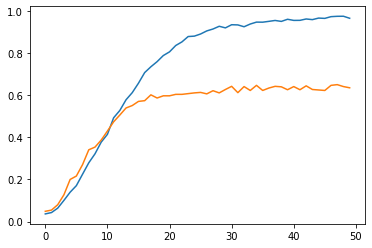

In [ ]:
plt.plot(celebrity_model.history["accuracy"])
plt.plot(celebrity_model.history["val_accuracy"])

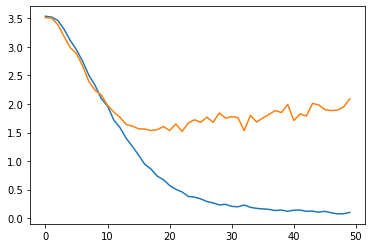

In [ ]:
plt.plot(celebrity_model.history["loss"])
plt.plot(celebrity_model.history["val_loss"])

In [ ]:
!curl -o test_slika.jpg https://www.whoa.in/download/leonardo-dicaprio-face-closeup-hd-wallpaper

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  385k  100  385k    0     0   873k      0 --:--:-- --:--:-- --:--:--  873k


In [ ]:
slika = plt.imread("/content/test_slika.jpg")

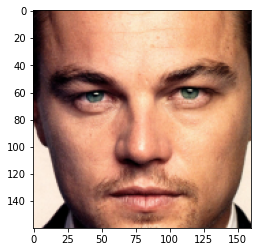

In [ ]:
face = face_cascade.detectMultiScale(slika, scaleFactor=1.3) # mora biti dobra slika(ne prepoznaje uvijek facu na slici)
if len(face)  == 0:
  print("Molim vas unesite bolju sliku.")
else:
  for (x, y, w, h) in face:
    slika_resized = cv2.resize(slika[y:y+h, x:x+w], (160,160), interpolation= cv2.INTER_AREA)
    plt.imshow(slika_resized)

In [ ]:
predikcija = (np.argmax(model.predict(slika_resized[tf.newaxis, ...])))
print(ispis_celeb[predikcija])

18


In [ ]:
 model_Celebritys =["Adriana Lima","Alex Lawther","Alexandra Daddario","Alvaro Morte","Ben Affleck","Bill Gates","Brian J. Smith","Chris Evans","Chris Hemsworth","Chris Pratt","Cristiano Ronaldo","Emilia Clarke","Emma Watson","Henry Cavil","Jason Momoa","Jennifer Lawrence","Johnny Depp","Josh Radnor","Leonardo DiCaprio","Madelaine Petsch","Megan Fox","Miley Cyrus","Morgan Freeman","Rihanna","Rober De Niro","Selena Gomez","Tom Cruise","Zac Efron","Barack Obama","Barbara Palvin","Camila Mendes","Ellen Page","Elon Musk","Kiernen Shipka","Scarlett Johansson"]

In [ ]:
print(model_Celebritys[predikcija])

Leonardo DiCaprio
